In [61]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import resnet18
from torchvision import datasets, models, transforms

# Load the pre-trained YOLO model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Use ResNet18 as the feature extractor
resnet = models.resnet18(pretrained=True)
modules = list(resnet.children())[:-1]
resnet = torch.nn.Sequential(*modules)

# Define a function to extract features from an image using YOLO and ResNet18
def extract_features(img):
    # Load the image
    img = Image.fromarray(img).convert('RGB')
    
    # Use YOLO to detect objects within the image
    results = model(img)
    boxes = results.xyxy[0].cpu().numpy()
    
    # Use ResNet18 to extract features from each object bounding box
    features = []
    for box in boxes:
        # Crop the image to the bounding box
        x1, y1, x2, y2 = box[:4].astype(int)
        obj_img = img.crop((x1, y1, x2, y2))
        
        # Preprocess the image for ResNet18
        preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        obj_img = preprocess(obj_img)
        
        # Extract features using ResNet18
        with torch.no_grad():
            feature = resnet(obj_img.unsqueeze(0)).squeeze().numpy()
            features.append(feature)
    
    return features




Using cache found in C:\Users\rawal/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-3-30 Python-3.10.9 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [63]:
import cv2
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

folder = 'dataset-v2'

images = load_images_from_folder(folder=folder)


In [64]:
# Example usage
features = extract_features(images[0])
print(len(features))

3


In [65]:
results = model(images[30])

In [66]:
print(results)

image 1/1: 720x1280 3 persons
Speed: 0.0ms pre-process, 18.2ms inference, 2.0ms NMS per image at shape (1, 3, 384, 640)


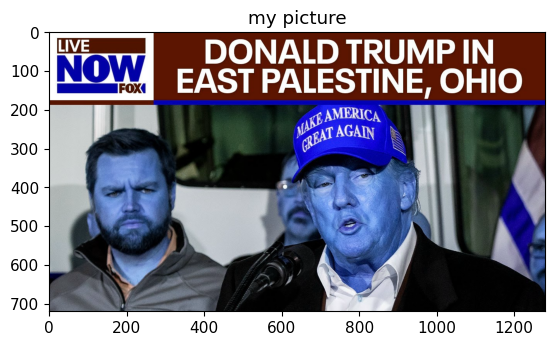

In [67]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.imshow(images[30])
plt.title('my picture')
plt.show()

In [1]:
# hog feature extractor

import cv2
import numpy as np
import torch
import torchvision.transforms as transforms

# parameters for 

class hogmodel():
    def __init__(self):
        self.winSize = (64, 64)
        blockSize = (16, 16)
        blockStride = (8, 8)
        cellSize = (8, 8)
        nbins = 9
        
        self.hog = cv2.HOGDescriptor(self.winSize, blockSize, blockStride, cellSize, nbins)

    def features(self, img):
        img = cv2.resize(img, self.winSize)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Compute the HOG features
        features = self.hog.compute(gray)

        # Convert the features to a PyTorch tensor
        # features = torch.from_numpy(np.transpose(features)).float()
        
        return features
    
# class siftmodel():
#     def __init__(self):
#         self.sift = cv2.xfeatures2d.SIFT_create()
    
#     def features(self, image):
#         # Load an image
#         img = cv2.imread('example_image.jpg')

#         # Convert the image to grayscale
#         gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#         # Detect SIFT keypoints and descriptors
#         keypoints, descriptors = self.sift.detectAndCompute(gray, None)
        
#         descriptors = torch.from_numpy(descriptors).float()
        
#         return descriptors
    

# sift = siftmodel()
hog = hogmodel()





In [2]:
import cv2
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

folder = 'dataset-v2'

images = load_images_from_folder(folder=folder)

In [3]:
print(len(images))

831


In [4]:
# we have 831 images

# extracting features
features_hog = []

for img in images:
    f = hog.features(img)
    # print(f)
    # print(f.numpy())
    features_hog.append(f.flatten())


In [5]:
print(features_hog[0], features_hog[0])

print(len(features_hog[0]))
print(np.array(features_hog).shape)

[0.1309936  0.05487607 0.0361949  ... 0.26525983 0.26525983 0.26525983] [0.1309936  0.05487607 0.0361949  ... 0.26525983 0.26525983 0.26525983]
1764
(831, 1764)


In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=5, learning_rate=350, n_iter=5000, random_state=0).fit_transform(np.array(features_hog))

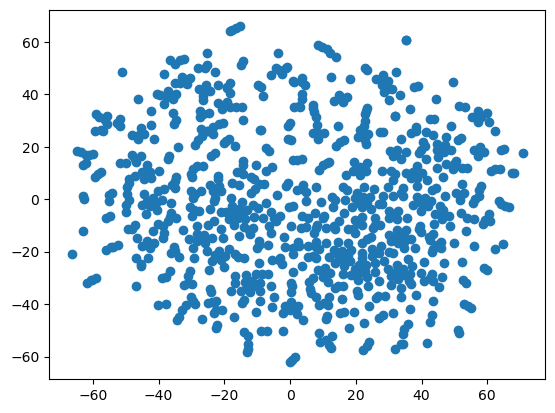

In [7]:
plt.scatter(tsne[:, 0], tsne[:, 1])
plt.show()

In [80]:
# tx, ty = tsne[:,0], tsne[:,1]
# tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
# ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

# import keras.utils as image

# r = 0.7
# from PIL import Image

# width = int(4000*r)
# height = int(3000*r)
# max_dim = 100
# images = []
# for i, filename  in enumerate(os.listdir(folder)):
#     img = image.load_img(folder+"/"+filename)
#     images.append(img)
# full_image = Image.new('RGBA', (width, height))


# for img, x, y in zip(images, tx, ty):
#     tile = img
#     rs = max(1, tile.width/max_dim, tile.height/max_dim)
#     tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
#     full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

# plt.figure(figsize = (26,26))
# plt.imshow(full_image)

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans, Birch, DBSCAN
from yellowbrick.cluster import KElbowVisualizer

c:\Users\rawal\anaconda3\envs\MlpDev\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\rawal\anaconda3\envs\MlpDev\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\rawal\anaconda3\envs\MlpDev\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\rawal\anaconda3\envs\MlpDev\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

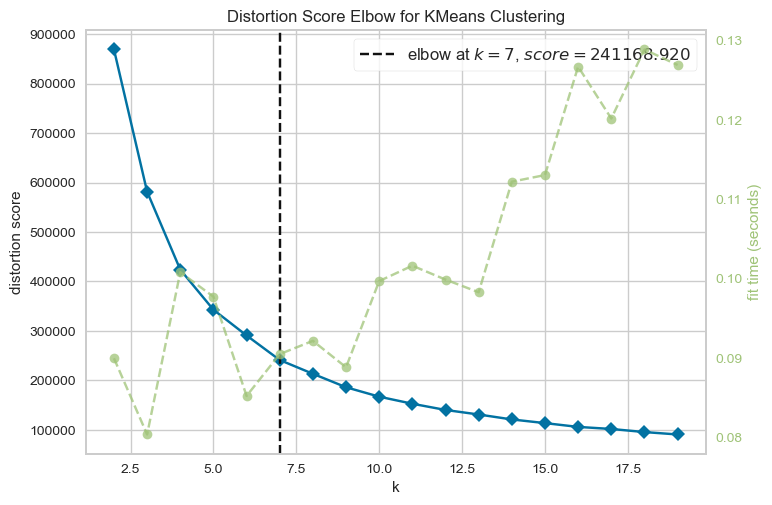

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
#create list to hold SSE values for each k
# Instantiate the clustering model and visualizer
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,20))
 
visualizer.fit(tsne)        # Fit the data to the visualizer
visualizer.show()

In [10]:
kmbest = KMeans(n_clusters = 7, random_state = 42)
kmbest.fit(tsne)

c:\Users\rawal\anaconda3\envs\MlpDev\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\rawal\anaconda3\envs\MlpDev\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


KMeans(n_clusters=7, random_state=42)

In [11]:
# scores

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, silhouette_score, cohen_kappa_score, calinski_harabasz_score, davies_bouldin_score

In [12]:
ss = silhouette_score(tsne, kmbest.labels_)
ch = calinski_harabasz_score(tsne, kmbest.labels_)
db = davies_bouldin_score(tsne, kmbest.labels_)

In [13]:
print('kmeans on hog features',ss, ch, db)

kmeans on hog features 0.3693087 742.5994472287571 0.788853360059307


kmeans on hog features 0.34446537 626.3124515931289 0.87583833032917


In [14]:
birch = Birch(n_clusters = 10).fit(tsne)
ss = silhouette_score(tsne, birch.labels_)
ch = calinski_harabasz_score(tsne, birch.labels_)
db = davies_bouldin_score(tsne, birch.labels_)
print('Birch on hog features',ss, ch, db)

Birch on hog features 0.31171036 629.3771633389192 0.8976333551277781


In [15]:
# dbscan
print(tsne[0])

def grid_search_dbscan(features):
    eps = [0.1, 0.2, 0.6, 0.8, 1]
    min_samples = [2, 4, 6, 8, 10]
    
    

    for eps in eps:
        for min_samp in min_samples:
            dbscan = DBSCAN(eps = eps, min_samples = min_samp).fit(features)
            audio_features_scaled_db_df = dbscan.labels_
            print(eps, min_samp)
            try:
                print('Labels : ', len(set(audio_features_scaled_db_df)))
                print('Calinski harabasz score : ', calinski_harabasz_score(features, dbscan.labels_))
                print('Davies Bouldin Score : ', davies_bouldin_score(features, dbscan.labels_))
                print('Silhouette Score : ', silhouette_score(features, dbscan.labels_))
                
            except:
                print()
                continue
                
                
                
# DBSCAN Grid Search
grid_search_dbscan(tsne)

[ 35.292698 -11.893326]
0.1 2
Labels :  2
Calinski harabasz score :  5.275790628186178
Davies Bouldin Score :  0.5743304269840104
Silhouette Score :  0.23246092
0.1 4
Labels :  1

0.1 6
Labels :  1

0.1 8
Labels :  1

0.1 10
Labels :  1

0.2 2
Labels :  4
Calinski harabasz score :  2.792055936091399
Davies Bouldin Score :  1.0339376893386667
Silhouette Score :  -0.2372059
0.2 4
Labels :  1

0.2 6
Labels :  1

0.2 8
Labels :  1

0.2 10
Labels :  1

0.6 2
Labels :  15
Calinski harabasz score :  2.9404246111433614
Davies Bouldin Score :  1.0548482376049206
Silhouette Score :  -0.5554695
0.6 4
Labels :  1

0.6 6
Labels :  1

0.6 8
Labels :  1

0.6 10
Labels :  1

0.8 2
Labels :  18
Calinski harabasz score :  3.2257798272694047
Davies Bouldin Score :  0.9848325967536022
Silhouette Score :  -0.593751
0.8 4
Labels :  1

0.8 6
Labels :  1

0.8 8
Labels :  1

0.8 10
Labels :  1

1 2
Labels :  21
Calinski harabasz score :  3.231748092468298
Davies Bouldin Score :  0.9767496239210897
Silhouette S

In [16]:
print(tsne)

[[ 35.292698  -11.893326 ]
 [ 17.741747  -11.327227 ]
 [-19.28569    42.28393  ]
 ...
 [  9.389356   -1.2630295]
 [ 45.185215  -33.489414 ]
 [  1.522374  -60.078808 ]]


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from sklearn.cluster import KMeans
import numpy as np

from torch.utils.data import Dataset
import natsort
from PIL import Image

# Define the deep clustering network
class DeepClusteringNet(nn.Module):
    def __init__(self, num_clusters):
        super(DeepClusteringNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_clusters)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 512 * 7 * 7)
        x = self.classifier(x)
        return x

# Load the dataset and apply data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        self.all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(self.all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image
    
my_dataset = CustomDataSet('dataset-v2', transform=train_transform)
train_loader = torch.utils.data.DataLoader(my_dataset , batch_size=15, shuffle=False, 
                               num_workers=0, drop_last=True)

# Initialize the deep clustering network and optimizer
dcn = DeepClusteringNet(num_clusters=10)
optimizer = optim.SGD(dcn.parameters(), lr=0.001, momentum=0.9)

# Train the deep clustering network
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0

    for i, inputs in enumerate(train_loader):
        optimizer.zero_grad()

        outputs = dcn(inputs)

        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

# Extract the deep features
features = np.zeros((len(train_dataset), num_clusters))

with torch.no_grad():
    for i, (inputs, labels) in enumerate(train_loader):
        outputs = dcn.features(inputs).view(inputs.size(0), -1)
        features[i*64:(i+1)*64] = outputs.numpy()



RuntimeError: shape '[15, 25088]' is invalid for input of size 1505280

In [96]:
# we will train it more on our thumbnails



NameError: name 'imgarray' is not defined

In [104]:
print('hel')

hel


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F



# Define the autoencoder architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(8, 4, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        # Decoder layers
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.deconv1 = nn.ConvTranspose2d(4, 8, kernel_size=3, padding=1)
        self.deconv2 = nn.ConvTranspose2d(8, 16, kernel_size=3, padding=1)
        self.deconv3 = nn.ConvTranspose2d(16, 3, kernel_size=3, padding=1)

    def forward(self, x):
        # Encoder
        x = F.relu(self.conv1(x))
        x, indices1 = self.pool(x)
        x = F.relu(self.conv2(x))
        x, indices2 = self.pool(x)
        x = F.relu(self.conv3(x))
        x, indices3 = self.pool(x)
        # Decoder
        x = self.unpool(x, indices3)
        x = F.relu(self.deconv1(x))
        x = self.unpool(x, indices2)
        x = F.relu(self.deconv2(x))
        x = self.unpool(x, indices1)
        x = self.deconv3(x)
        return x



# Load the dataset and apply data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

my_dataset = CustomDataSet('dataset-v2', transform=train_transform)
train_loader = torch.utils.data.DataLoader(my_dataset , batch_size=15, shuffle=False, 
                               num_workers=0, drop_last=True)

# Initialize the autoencoder
# device = torch.get_device('cuda')
autoencoder = ConvAutoencoder().to(device='cuda:0')

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Train the autoencoder
for epoch in range(10):
    print(epoch)
    for i, data in enumerate(train_loader):
        data = data.to(device='cuda:0')
        optimizer.zero_grad()
        reconstructed_data = autoencoder(data)
        loss = loss_fn(reconstructed_data, data)
        loss.backward()
        optimizer.step()




0
0


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [115]:

autoencoder.eval()
embeddings = []
with torch.no_grad():
    for data in train_loader:
        output = autoencoder.conv3(F.relu(autoencoder.conv2(F.relu(autoencoder.conv1(data)))))
        embeddings.append(output.view(output.size(0), -1))
    embeddings = torch.cat(embeddings, dim=0)
    # use k-means or other clustering algorithms to cluster the embeddings
    # and assign labels to the test images accordingly

In [ ]:
print(embeddings)